In [634]:
from matplotlib import pyplot
import numpy as np
from math import log, exp

In [635]:
x_max = 10
t_max = 10

x_steps = 10
t_steps = 1000

dx = x_max / x_steps
dt = t_max / t_steps

def D(x):
    return (x + 1) * (11 - x)

def f(x):
    return x

def U0x(x):
    return x * (10 - x) * (10 - x)

def Ut0(t):
    return 0

def Ut10(t):
    return 0

In [636]:
def solve_with_explicit_scheme(t_steps, x_steps, dt, dx):
    result = [[0 for _ in range(x_steps + 1)] for _ in range(t_steps + 1)]
    for t_index in range(t_steps + 1):
        for x_index in range(x_steps + 1):
            t = t_index * dt
            x = x_index * dx
            u = 0
            if t_index == 0:
                u = U0x(x)
            elif x_index == 0:
                u = Ut0(t)
            elif(x_index == x_steps):
                u = Ut10(t)
            else:
                u = (1 - 2*dt*D(x)/(dx*dx) - dt*f(x)) * result[t_index - 1][x_index] + dt*D(x)/(dx*dx) * (result[t_index - 1][x_index + 1] + result[t_index - 1][x_index - 1]) + 5*dt
                
            result[t_index][x_index] = u

    return result

In [637]:
def solve_with_implicit_scheme(t_steps, x_steps, dt, dx):
    result = [[0 for _ in range(x_steps + 1)] for _ in range(t_steps + 1)]

    for t_index in range(t_steps + 1):
        t = t_index * dt
        result[t_index][0] = Ut0(t)
        result[t_index][x_steps] = Ut10(t)
    
    for x_index in range(x_steps + 1):
        x = x_index * dx
        result[0][x_index] = U0x(x)

    for t_index in range(1, t_steps + 1):
        a = [0 for _ in range(x_steps)]
        b = [0 for _ in range(x_steps)]
        c = [0 for _ in range(x_steps)]
        d = [0 for _ in range(x_steps)]
        p = [0 for _ in range(x_steps)]
        q = [0 for _ in range(x_steps)]

        for x_index in range(1, x_steps):
            x = x_index * dx

            a[x_index - 1] = dt * D(x) / (dx * dx)
            c[x_index - 1] = dt * D(x) / (dx * dx)
            b[x_index - 1] = 1 + 2 * dt * D(x) / (dx * dx) + dt * f(x)
            d[x_index - 1] = result[t_index - 1][x_index] + 5 * dt

        p[0] = c[0] / b[0]
        q[0] = (d[0] + a[0] * result[t_index][0]) / b[0]

        for x_index in range(1, x_steps-1):
            denom = b[x_index] - a[x_index] * p[x_index-1]
            p[x_index] = c[x_index] / denom
            q[x_index] = (d[x_index] + a[x_index] * q[x_index-1]) / denom

        result[t_index][x_steps-1] = p[x_steps-2] * result[t_index][x_steps] + q[x_steps-2]

        for x_index in range(x_steps-2, 0, -1):
            result[t_index][x_index] = p[x_index-1] * result[t_index][x_index+1] + q[x_index-1]

    return result

In [638]:
def standart_deviation(U1, U2, x_step_multiplier, t_step_multiplier):
    sum = 0
    count = 0
    for t in range(len(U2)):
        for x in range(len(U2[t])):
            count += 1
            sum += (U1[t * t_step_multiplier][x * x_step_multiplier] - U2[t][x]) ** 2

    return (sum / count) ** 0.5

In [639]:
def show_plot(t, x, u, title = ""):
    u = np.array(u)
    t, x = np.meshgrid(x, t)
    fig = pyplot.figure()
    ax = fig.add_subplot(projection='3d')
    plot = ax.plot_surface(t, x, u)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_zlabel("U")
    ax.view_init(elev=30, azim=45, roll=15)
    ax.set_title(title)
    pyplot.show()
    

In [640]:
def approximation_experiments_for_fixed_dx(method : callable, t_steps, x_steps, dt, dx, experiments_count = 8):
    original_t_steps = t_steps

    steps = []
    deviations = []
    solutions = []
    for i in range(experiments_count):
        t_steps_multiplier = 2 ** i
        t_steps = original_t_steps * t_steps_multiplier
        dt = t_max / t_steps
        u = method(t_steps, x_steps, dt, dx)
        steps.append(dt)
        solutions.append(u)
    
    for i in range(experiments_count):
        u1 = solutions[-1]
        u2 = solutions[i]
        deviations.append(standart_deviation(u1, u2, 1, 2 ** (experiments_count - 1 - i)))
    pyplot.plot(steps, deviations, 'o-',)
    pyplot.xlabel("t step")
    pyplot.ylabel("Standart Deviation")
    pyplot.show()

    return
        

In [641]:
def approximation_experiments_for_fixed_dt(method : callable, t_steps, x_steps, dt, dx, experiments_count = 4):
    original_x_steps = x_steps


    steps = []
    deviations = []
    solutions = []
    for i in range(experiments_count):
        x_steps_multiplier = 2 ** i
        x_steps = original_x_steps * x_steps_multiplier
        dx = x_max / x_steps
        u = method(t_steps, x_steps, dt, dx)
        steps.append(dx)
        solutions.append(u)

    
    for i in range(experiments_count):
        u1 = solutions[-1]
        u2 = solutions[i]
        deviations.append(standart_deviation(u1, u2, 2 ** (experiments_count - 1 - i), 1))
    pyplot.plot(steps, deviations, 'o-',)
    pyplot.xlabel("x step")
    pyplot.ylabel("Standart Deviation")
    pyplot.show()

    return

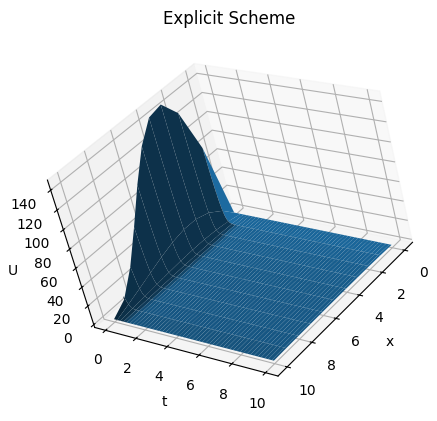

In [642]:
u = solve_with_explicit_scheme(t_steps, x_steps, dt, dx)
t = np.linspace(0, t_max, t_steps + 1)
x = np.linspace(0, x_max, x_steps + 1)
show_plot(t, x, u, "Explicit Scheme")

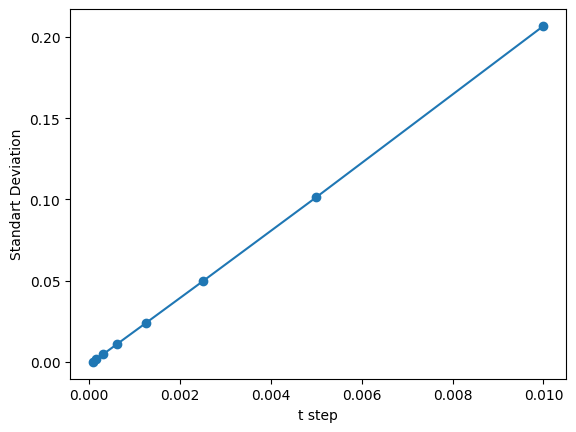

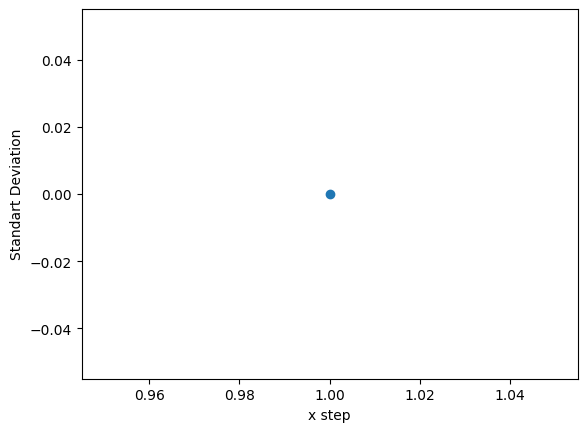

In [ ]:
approximation_experiments_for_fixed_dx(solve_with_explicit_scheme, t_steps, x_steps, dt, dx, 8)
approximation_experiments_for_fixed_dt(solve_with_explicit_scheme, t_steps * 64, x_steps, dt / 64, dx, 4)


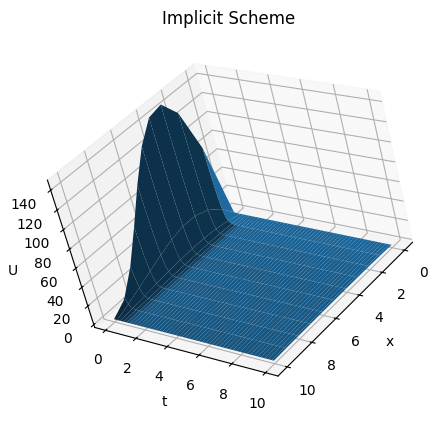

In [644]:
u = solve_with_implicit_scheme(t_steps, x_steps, dt, dx)
t = np.linspace(0, t_max, t_steps + 1)
x = np.linspace(0, x_max, x_steps + 1)
show_plot(t, x, u, "Implicit Scheme")

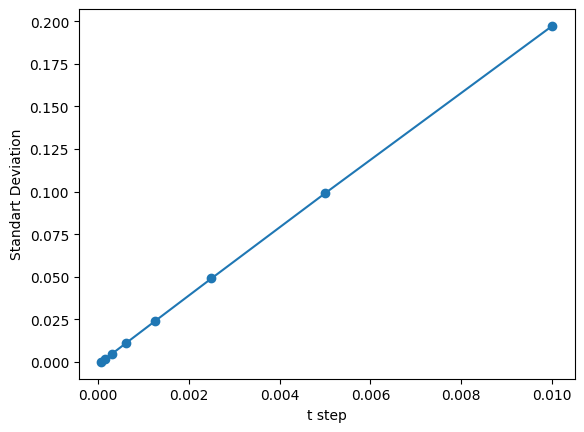

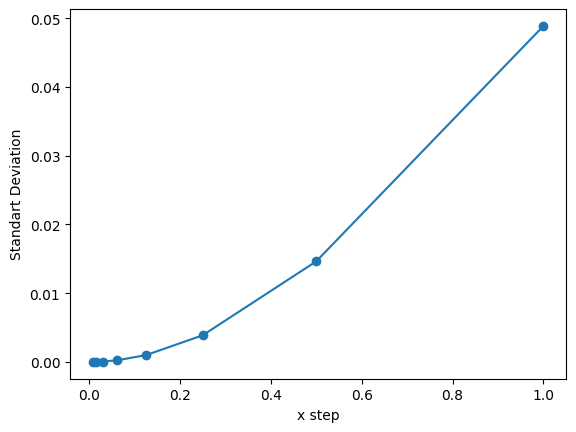

In [645]:
approximation_experiments_for_fixed_dx(solve_with_implicit_scheme, t_steps, x_steps, dt, dx, 8)
approximation_experiments_for_fixed_dt(solve_with_implicit_scheme, t_steps, x_steps, dt, dx, 8)
